In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4313386936655179480
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8372991640796025288
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4145345766269110751
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5245292017021888568
physical_device_desc: "device: XLA_GPU device"
]


In [42]:
# Load raw data
def Load_RAW(path):
    '''
        Input:
            path: folder of the dataset
        
        Output:
            raw_data:  list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
    '''
    
    # Container for the dataset
    raw_data = []
    cvs = []
    labels = []
    # Load every file inside the folder
    for file_name in tqdm(os.listdir(path)):

        try:
            # Get audio data and sampling rate
            audio, sampling_rate = librosa.load(os.path.join(path, file_name), res_type='kaiser_fast')
            # Split the file name
            name_splitted = re.split('[-.]', file_name)
            
            # Append a row of 3 elements
            raw_data.append(audio)
            cvs.append(name_splitted[0])
            labels.append(name_splitted[3])
        except Exception as e:
            pass
    
    # Convert to numpy array
    raw_audio = np.asarray(raw_data)
    cvs = np.asarray(cvs, dtype=int)
    labels = np.asarray(labels, dtype=int)
    
    # onehot encode the labels in 50 classes
    onehot_labels = to_categorical(labels, num_classes=50)
    
    return raw_audio, cvs, onehot_labels



def Split_Folds(raw_audio, cvs, labels, verbose=False):
    '''
        Input:
            raw_audio: list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
            verbose:   flag used to print produced folds information
        
        Output:
            f{1,2,3,4,5}:      folds that contains the raw data and labels
    '''
    
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    
    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):
        
        if cvs[num] == 1:
            f1.append((audio, labels[num]))
        elif cvs[num] == 2:
            f2.append([audio, labels[num]])
        elif cvs[num] == 3:
            f3.append([audio, labels[num]])
        elif cvs[num] == 4:
            f4.append([audio, labels[num]])
        elif cvs[num] == 5:
            f5.append([audio, labels[num]])
    
    # Convert to numpy array
    f1 = np.asarray(f1, dtype=object)
    f2 = np.asarray(f2, dtype=object)
    f3 = np.asarray(f3, dtype=object)
    f4 = np.asarray(f4, dtype=object)
    f5 = np.asarray(f5, dtype=object)
    
    if verbose:
        print("Folds size: %2d - %2d - %2d - %2d - %2d" % (len(f1), len(f2), len(f3), len(f4), len(f5)))

        print("Folds sample shape: ", len(f1[0]))

        print("Folds sample data shape: ", f1[0][0].shape)
        
        print("Folds sample label type: ", f1[0][1].shape)
    
    return f1, f2, f3, f4, f5


def Split_Data_Label(dataset):
    
    
    data = []
    label = []
    
    for i in range (len(dataset)):
        data.append(dataset[i][0])
        label.append(dataset[i][1])

    
    data = np.asarray(data)
    label = np.asarray(label)
    
    return data, label


def RawPreprocessing(raw_audio, labels, wnd_size=20480):
    
    new_labels = []
    augmented_spec = []
    
    # Normalize the raw data
    norm_factor = np.percentile(raw_audio, 99) - np.percentile(raw_audio, 5)
    raw_audio = raw_audio / norm_factor

    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):
        
        # Split into segments
        for idx in range(0, len(raw_audio[0]), int(wnd_size/2)):
            
            tmp = audio[idx:idx+wnd_size]
            tmp_data = np.zeros((wnd_size, 1), dtype=np.float32)
            
            if(len(tmp) == wnd_size):
                
                # Fill temp numpy array
                for i in range(wnd_size):
                    tmp_data[i][0] = tmp[i]
                
                augmented_spec.append(tmp_data)
                new_labels.append(labels[num])
    '''
    new_data = []
    # switch dimensions
    for sample in augmented_spec:
        tmp = []
        for element in sample:
            tmp.append(element)
        new_data.append(tmp)
    '''
    augmented_spec = np.array(augmented_spec, dtype=np.float32)
    new_labels = np.array(new_labels, dtype=np.int)
    return augmented_spec, new_labels

# Rawnet Model

In [53]:
def RawNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    #print(input_shape)
    #model = tf.keras.layers.Reshape((input_shape[0], 1))(X_input)
    
    
    # Basic Feature extraction
    model = tf.keras.layers.Conv1D(40, kernel_size=8, strides=1, padding='same', name='conv0')(X_input)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv1D(40, kernel_size=8, strides=1, padding='same', name='conv1')(model)
    model = tf.keras.layers.BatchNormalization(axis=1)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.MaxPool1D(pool_size=128, strides=128, padding='same', name='max_pool')(model)
    
    model = tf.keras.layers.Reshape((40, 160, 1))(model)
    
    model = tf.keras.layers.Conv2D(24, kernel_size=(6, 6), strides=(1, 1), padding='same', name='conv3')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv2D(24, kernel_size=(6, 6), strides=(1, 1), padding='same', name='conv4')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv2D(48, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv5')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv2D(48, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv6')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', name='conv7')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Flatten()(model)
    
    model = tf.keras.layers.Dense(200, activation='relu', name='ffc')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    model = tf.keras.layers.Dense(10, activation='softmax', name='out')(model)

    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = model, name='RawNet')
    
    return model

# Data Loading

In [4]:
# Load raw data
PATH = 'audio'
raw_files, cvs, labels = Load_RAW(PATH)

# Split the different folds
f1, f2, f3, f4, f5 = Split_Folds(raw_files, cvs, labels, verbose=True)

100%|██████████| 2000/2000 [00:00<00:00, 667670.17it/s]

Folds size: 400 - 400 - 400 - 400 - 400
Folds sample shape:  2
Folds sample data shape:  (110250,)
Folds sample label type:  (50,)


In [5]:
f1d, f1l = Split_Data_Label(f1)
f2d, f2l = Split_Data_Label(f2)
f3d, f3l = Split_Data_Label(f3)
f4d, f4l = Split_Data_Label(f4)
f5d, f5l = Split_Data_Label(f5)

In [43]:
f1p, lf1p = RawPreprocessing(f1d, f1l)
f2p, lf2p = RawPreprocessing(f2d, f2l)
f3p, lf3p = RawPreprocessing(f3d, f3l)
f4p, lf4p = RawPreprocessing(f4d, f4l)
f5p, lf5p = RawPreprocessing(f5d, f5l)

100%|██████████| 400/400 [00:22<00:00, 17.63it/s]


In [44]:
print(f1p.shape)

(3600, 20480, 1)


Model: "RawNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20480, 1)]        0         
_________________________________________________________________
conv0 (Conv1D)               (None, 20480, 40)         360       
_________________________________________________________________
activation_7 (Activation)    (None, 20480, 40)         0         
_________________________________________________________________
conv1 (Conv1D)               (None, 20480, 40)         12840     
_________________________________________________________________
batch_normalization_6 (Batch (None, 20480, 40)         81920     
_________________________________________________________________
activation_8 (Activation)    (None, 20480, 40)         0         
_________________________________________________________________
max_pool (MaxPooling1D)      (None, 160, 40)           0    

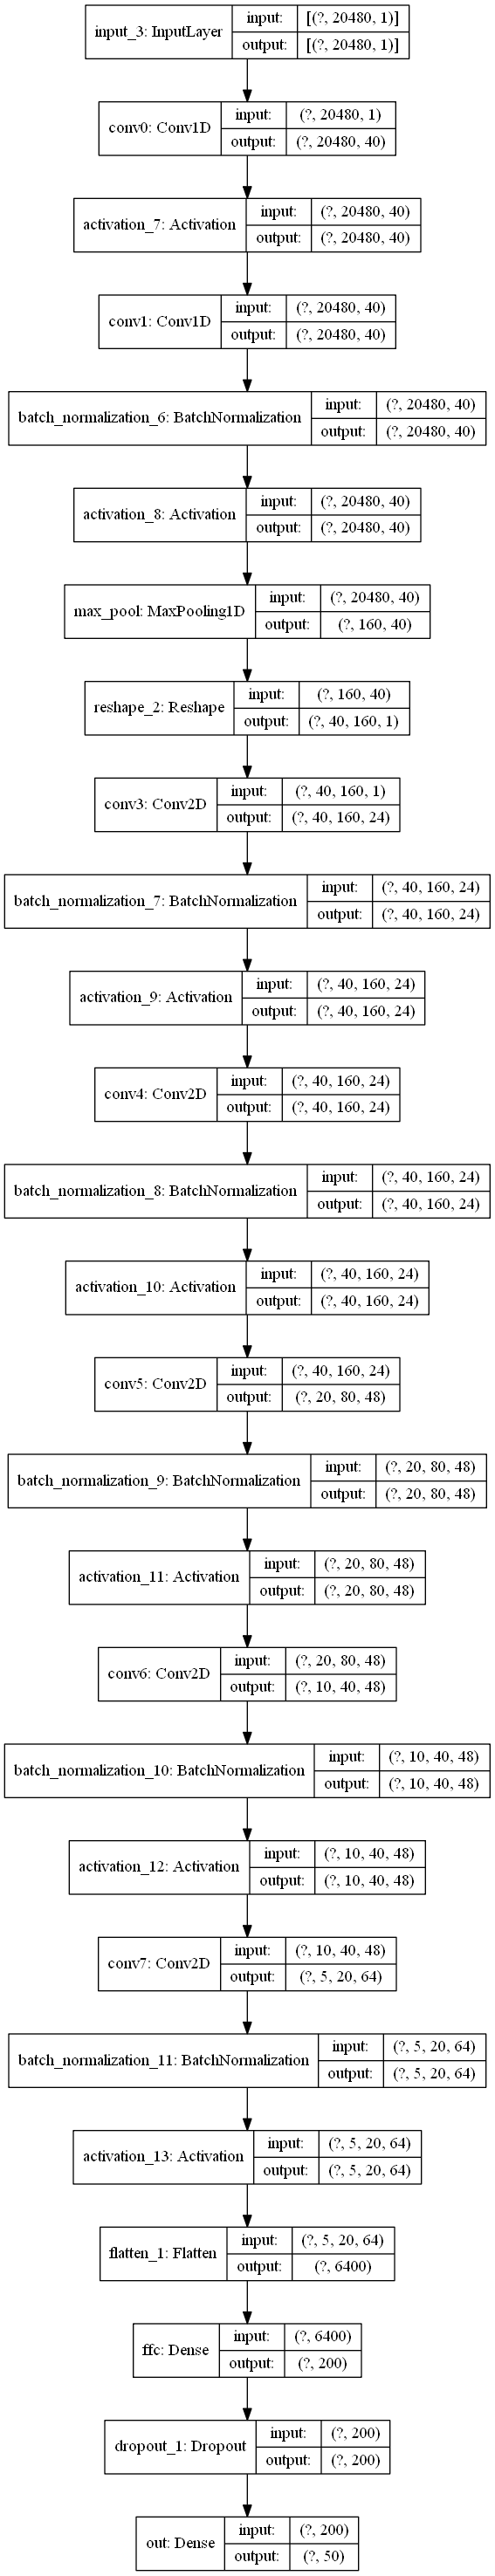

In [56]:
input_shape = f1p[0].shape
RawNet = RawNet(input_shape)

print(RawNet.summary())

plot_model(RawNet, show_shapes=True, show_layer_names=True)

In [54]:
def CreateTrainingSet(f1, f2, f3, lf1, lf2, lf3, batch_size=200):
    
    # Create training set
    merged_training_data = np.concatenate((f1, f2, f3))
    merged_training_label = np.concatenate((lf1, lf2, lf3))
    
    merged_training_data = merged_training_data.astype(np.float32)
    merged_training_label = merged_training_label.astype(np.int)

    # Create and cache training
    training_dataset = tf.data.Dataset.from_tensor_slices((merged_training_data, merged_training_label))
    training_dataset = training_dataset.batch(batch_size=batch_size)
    training_dataset = training_dataset.cache("training_cache")
    training_dataset = training_dataset.prefetch(buffer_size=1)
    
    return training_dataset


def CreateValidationSet(f1, lf1, batch_size=200):
    
    f1 = f1.astype(dtype=np.float32)
    lf1 = lf1.astype(dtype=np.int)
    
    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((f1, lf1))
    validation_dataset = validation_dataset.cache("validation_cache")
    validation_dataset = validation_dataset.batch(batch_size=batch_size)
    validation_dataset = validation_dataset.prefetch(buffer_size=1)
    
    return validation_dataset

In [57]:
opt = tf.keras.optimizers.Adam(lr=0.001)
RawNet.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [58]:
training_dataset = CreateTrainingSet(f1p, f2p, f3p, lf1p, lf2p, lf3p)

validation_dataset = CreateValidationSet(f4p, lf4p)

In [59]:
max_epochs = 50

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):

    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = RawNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = RawNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))

Epoch  1: 	 t-loss: 4.128014 	 t-acc: 0.011019 	 v-loss: 3.912028 	 v-acc: 0.020000 	 time: 38.253
Epoch  2: 	 t-loss: 3.912742 	 t-acc: 0.010833 	 v-loss: 3.912027 	 v-acc: 0.020000 	 time: 36.232
Epoch  3: 	 t-loss: 3.912740 	 t-acc: 0.010833 	 v-loss: 3.912027 	 v-acc: 0.020000 	 time: 36.220
Epoch  4: 	 t-loss: 3.912742 	 t-acc: 0.010833 	 v-loss: 3.912027 	 v-acc: 0.020000 	 time: 36.245
Epoch  5: 	 t-loss: 3.912743 	 t-acc: 0.010833 	 v-loss: 3.912026 	 v-acc: 0.020000 	 time: 36.301


KeyboardInterrupt: 

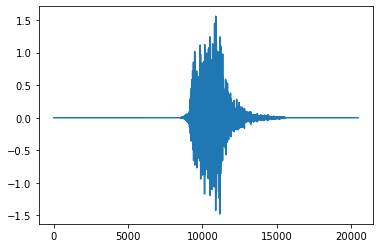

In [45]:

plt.figure()
plt.plot(f1p[4][:])
plt.show()

(20480, 1)
[0. 0. 0. ... 0. 0. 0.]


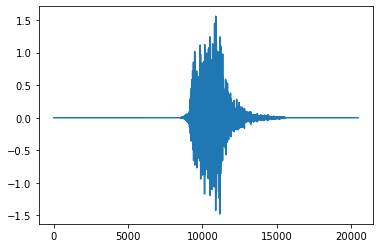

In [51]:
print(f1p[0][:].shape)
test = f1p[4, :].reshape(20480)
print(test)


plt.figure()
#for ptn in test:
#    print(ptn[0])
plt.plot(test)
plt.show()